#Устанавливаем зависимости и загружаем с гитхаба модель YOLOv5

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Загружаем датасет с правильнйо структурой под сетку


In [ ]:
# подключем диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
import shutil
import json
import numpy as np
import io
from moviepy.editor import *
import cv2
import numpy as np
from tqdm import tqdm_notebook
from moviepy.editor import *
from base64 import b64encode
from PIL import Image, ImageDraw, ImageFont # Модули работы с изображениями

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2785280/45929032 bytes (6.1%)6520832/45929032 bytes (14.2%)10133504/45929032 bytes (22.1%)13705216/45929032 bytes (29.8%)17383424/45929032 bytes (37.8%)21028864/45929032 bytes (45.8%)24682496/45929032 bytes (53.7%)28557312/45929032 bytes (62.2%)32407552/45929032 bytes (70.6%)36134912/45929032 bytes (78.7%)39845888/45929032 bytes (86.8%)43532288/45929032 bytes (94.8%)

# База

## *

In [ ]:
path = '/content/drive/My Drive/Базы/Самолеты/' # Путь к директории на диске, где находятся изображения

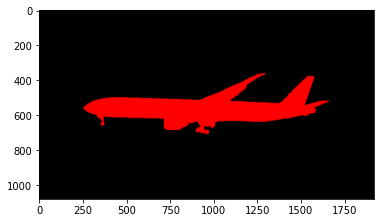

In [ ]:
# Открываем файл сегментированной модели
filename = 'airplane_65' # Имя файла
image = Image.open(path+'Segment/'+filename+'.jpg') # Загружаем изображение сегментированной модели
img1 = ImageDraw.Draw(image) # Создаем экземпляр изображения
plt.imshow(image) # Рисуем изображение

minX = 248    minY = 358    maxX = 1665    maxY = 711


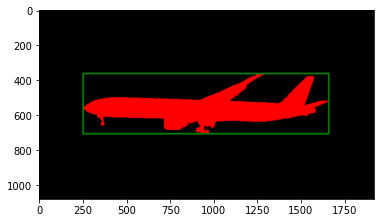

In [ ]:
# Находим координаты ограничивающего бокса (ищем по красному параметру в массиве RGB)
image_n = np.array(image) # Переводим в numpy
image_red = image_n[:,:,0] # Оставляем только красный цвет
itemindex = np.array(np.where(image_red > 20 )) # Ищем все элементы, в которых значение красного цвета больше 20
# np.where веренет двумерный кортеж, где первый элемент соответсвует найденным строкам, второй - найженным столбцам
minY = min (itemindex[0]) # minY будет соответствовать минимальному значению в первом элементе itemindex
maxY = max (itemindex[0]) # maxY будет соответствовать максимальному значению в первом элементе itemindex
minX = min (itemindex[1]) # minX будет соответствовать минимальному значению во втором элементе itemindex
maxX = max (itemindex[1]) # maxX будет соответствовать максимальному значению во втором элементе itemindex
print ('minX = ',minX, '    minY = ', minY, '    maxX = ', maxX, '    maxY = ',maxY, sep='') # Выводим найденные значения

# Рисуем ограничивающую рамку
for i in range(10):
  img1.rectangle([minX+i,minY+i,maxX-i,maxY-i], outline = 'green')
plt.imshow(image)

In [ ]:
# Получение координат ограничивающей рамки
def getXY(image):
    image_red = np.array(image)[:,:,0]  # Считываем красный канал изображения
    indexes = np.where(image_red > 20) # Получаем индексы пискселей красного цвета
    image_shape =  image_red.shape
    x1 = min(indexes[1])
    y1 = min(indexes[0])
    x2 = max(indexes[1])
    y2 = max(indexes[0]) 

    w = x2 - x1
    h = y2 - y1

    x = x1 + w/2
    y = y1 + h/2

    return ' '.join(['0', str(x/image_shape[1]), str(y/image_shape[0]), str(w/image_shape[1]), str(h/image_shape[0])])

In [ ]:
getXY(image)

'0 0.4981770833333333 0.4949074074074074 0.7276041666666667 0.30833333333333335'

In [ ]:
# /content/drive/MyDrive/Базы/Самолеты/Самолеты
os.listdir(f'{path}Segment/')[:10]

['airplane_1.jpg',
 'airplane_5.jpg',
 'airplane_2.jpg',
 'airplane_3.jpg',
 'airplane_6.jpg',
 'airplane_4.jpg',
 'airplane_10.jpg',
 'airplane_21.jpg',
 'airplane_16.jpg',
 'airplane_11.jpg']

In [ ]:
os.listdir(f'{path}Самолеты/')[:10]

['airplane_24.jpg',
 'airplane_26.jpg',
 'airplane_30.jpg',
 'airplane_23.jpg',
 'airplane_31.jpg',
 'airplane_25.jpg',
 'airplane_27.jpg',
 'airplane_29.jpg',
 'airplane_28.jpg',
 'airplane_32.jpg']

In [ ]:
!rm -r '/content/data/labels/train'
!rm -r '/content/data/images/train'
os.makedirs('/content/data/labels/train/', exist_ok=True)
os.makedirs('/content/data/images/train/', exist_ok=True)

k=0
for seg in os.listdir(f'{path}Segment/'):
    image = Image.open(f'{path}Segment/{seg}')
    with  open(f'/content/data/labels/train/{k}.txt', 'w') as f:
        f.write(getXY(image))
    
    shutil.copy2(src=f'{path}/Самолеты/{seg}',  dst =  f'/content/data/images/train/{k}.jpg')
    k+=1

rm: cannot remove '/content/data/labels/train': No such file or directory
rm: cannot remove '/content/data/images/train': No such file or directory


In [ ]:
# val

!rm -r '/content/data/labels/valid'
!rm -r '/content/data/images/valid'
os.makedirs('/content/data/labels/valid/', exist_ok=True)
os.makedirs('/content/data/images/valid/', exist_ok=True)

files = os.listdir('/content/data/labels/train')
ind = np.random.randint(0, len(files), int(len(files)*0.2))
err = 0
for i in np.unique(ind):
    try:
        shutil.move(src=f'/content/data/labels/train/{files[i]}',         dst=f'/content/data/labels/valid/{files[i]}')
        shutil.move(src=f'/content/data/images/train/{files[i][:-3]}jpg', dst=f'/content/data/images/valid/{files[i][:-3]}jpg')
    except:
        print(err+1)

rm: cannot remove '/content/data/labels/valid': No such file or directory
rm: cannot remove '/content/data/images/valid': No such file or directory


In [ ]:
# test

!rm -r '/content/data/labels/test'
!rm -r '/content/data/images/test'
os.makedirs('/content/data/labels/test/', exist_ok=True)
os.makedirs('/content/data/images/test/', exist_ok=True)

files = os.listdir('/content/data/labels/train')
ind = np.random.randint(0, len(files), int(len(files)*0.01))
err = 0
for i in np.unique(ind):
    try:
        shutil.move(src=f'/content/data/labels/train/{files[i]}',         dst=f'/content/data/labels/test/{files[i]}')
        shutil.move(src=f'/content/data/images/train/{files[i][:-3]}jpg', dst=f'/content/data/images/test/{files[i][:-3]}jpg')
    except:
        print(err+1)

rm: cannot remove '/content/data/labels/test': No such file or directory
rm: cannot remove '/content/data/images/test': No such file or directory


## json

In [ ]:
def json_to_txt():
    txt = []
    txt.append(str(json_data[ll[i]]['regions']['0']['region_attributes']['Class']))
    cor = json_data[ll[i]]['regions']['0']['shape_attributes']
    txt.append(str((cor['x'] + cor['width']/2) / np.array(Image.open(img)).shape[1]))
    txt.append(str((cor['y'] + cor['height']/2)  / np.array(Image.open(img)).shape[0]))
    txt.append(str(cor['width']  / np.array(Image.open(img)).shape[1]))
    txt.append(str(cor['height'] / np.array(Image.open(img)).shape[0]))
    return ' '.join(txt)

path = 'Наша база с фото...'
list_class = os.listdir(path)
list_class

In [ ]:
for i in range(len(list_class)):
    g = list_class[i] 
    for filename in os.listdir(f'{path}{g}'):
        if 'jpg' in filename:
            img = f'{path}{g}/{filename}'
         

In [ ]:
!rm -r '/content/data/labels/train'
!rm -r '/content/data/images/train'
os.makedirs('/content/data/labels/train/', exist_ok=True)
os.makedirs('/content/data/images/train/', exist_ok=True)
k = 0
for i in range(len(list_class)):
    g = list_class[i] 
    k+=1
    for filename in os.listdir(f'{path}{g}'):
        if 'json' in filename:
            with open(f'{path}{g}/{filename}') as f:
                json_data = json.load(f)
            ll = list(json_data.keys())

            for i in range(len(ll)):
                x = json_data[ll[i]]['filename'][:-4]
                with  open(f'/content/data/labels/train/{k}_{x}.txt', 'w') as f:
                    f.write(json_to_txt())
        else:
            shutil.copy2(src=f'{path}{g}/{filename}',  dst =  f'/content/data/images/train/{k}_{filename}')

In [ ]:
!rm -r '/content/data/labels/valid'
!rm -r '/content/data/images/valid'
os.makedirs('/content/data/labels/valid/', exist_ok=True)
os.makedirs('/content/data/images/valid/', exist_ok=True)

files = os.listdir('/content/data/labels/train')
ind = np.random.randint(0, len(files), 200)
err = 0
for i in np.unique(ind):
    try:
        shutil.move(src=f'/content/data/labels/train/{files[i]}',         dst=f'/content/data/labels/valid/{files[i]}')
        shutil.move(src=f'/content/data/images/train/{files[i][:-3]}jpg', dst=f'/content/data/images/valid/{files[i][:-3]}jpg')
    except:
        print(err+1)

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat /content/data.yaml

train: /content/data/images/train
val: /content/data/images/valid

nc: 1
names: ['prod']

# Настраиваем конфигурацию модели и архитектуру

Я использовал самую большую сеть YOLOv5x

Сетей есть несколько, можно выбрать разные, все в репозитории есть.

Например YOLOv5s очень быстро предикт делает

Подробное описание [здесь](https://models.roboflow.com/object-detection/yolov5)

In [ ]:
yaml_file = "train: //content/data/images/train\nval: //content/data/images/valid\n\nnc: 1\nnames: ['airplane']"

with open("//content/data.yaml", "w") as f:
  f.write(yaml_file)

In [ ]:
# define number of classes based on YAML
import yaml
with open("/content/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#здесь можно поменять модель
%cat /content/yolov5/models/yolov5x.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))


In [ ]:
#здесь можно поменять модель
%%writetemplate /content/yolov5/models/custom_yolov5x.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Обучение

Некоторые аргументы для обучения:

- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. 
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
#НЕОБХОДИМО УКАЗАТЬ ПРАВИЛЬНУЮ МОДЕЛЬ YOLOv5 чтобы везде была одинаковая
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 200 --data '../data.yaml' --cfg ./models/custom_yolov5x.yaml --weights '' --name yolov5x_results  --cache

/content/yolov5
Using torch 1.7.0+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5x.yaml', data='../data.yaml', device='', epochs=200, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], local_rank=-1, log_imgs=16, multi_scale=False, name='yolov5x_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/yolov5x_results3', single_cls=False, sync_bn=False, total_batch_size=16, weights='', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2020-12-15 18:14:00.139502: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum















#Запуск предикта с весами


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
# можно запредиктить всю папку

!python detect.py --weights '/content/drive/MyDrive/Базы/Самолеты/weights/YOLOv5.pt' --img 416 --conf 0.6 --source '/content/data/images/test'

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.6, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/data/images/test', update=False, view_img=False, weights=['/content/drive/MyDrive/Базы/Самолеты/weights/YOLOv5.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPS
image 1/8 /content/data/images/test/125.jpg: 256x416 1 airplanes, Done. (0.012s)
image 2/8 /content/data/images/test/132.jpg: 256x416 1 airplanes, Done. (0.011s)
image 3/8 /content/data/images/test/319.jpg: 256x416 1 airplanes, Done. (0.011s)
image 4/8 /content/data/images/test/413.jpg: 256x416 1 airplanes, Done. (0.011s)
image 5/8 /content/data/images/test/429.jpg: 256x416 1 airplanes, Done. (0.011s)
image 6/8 /content/data/images/test/509.jpg: 256x416 1 airplanes, Done. (0.010s)
image 7/8 /content/data/im

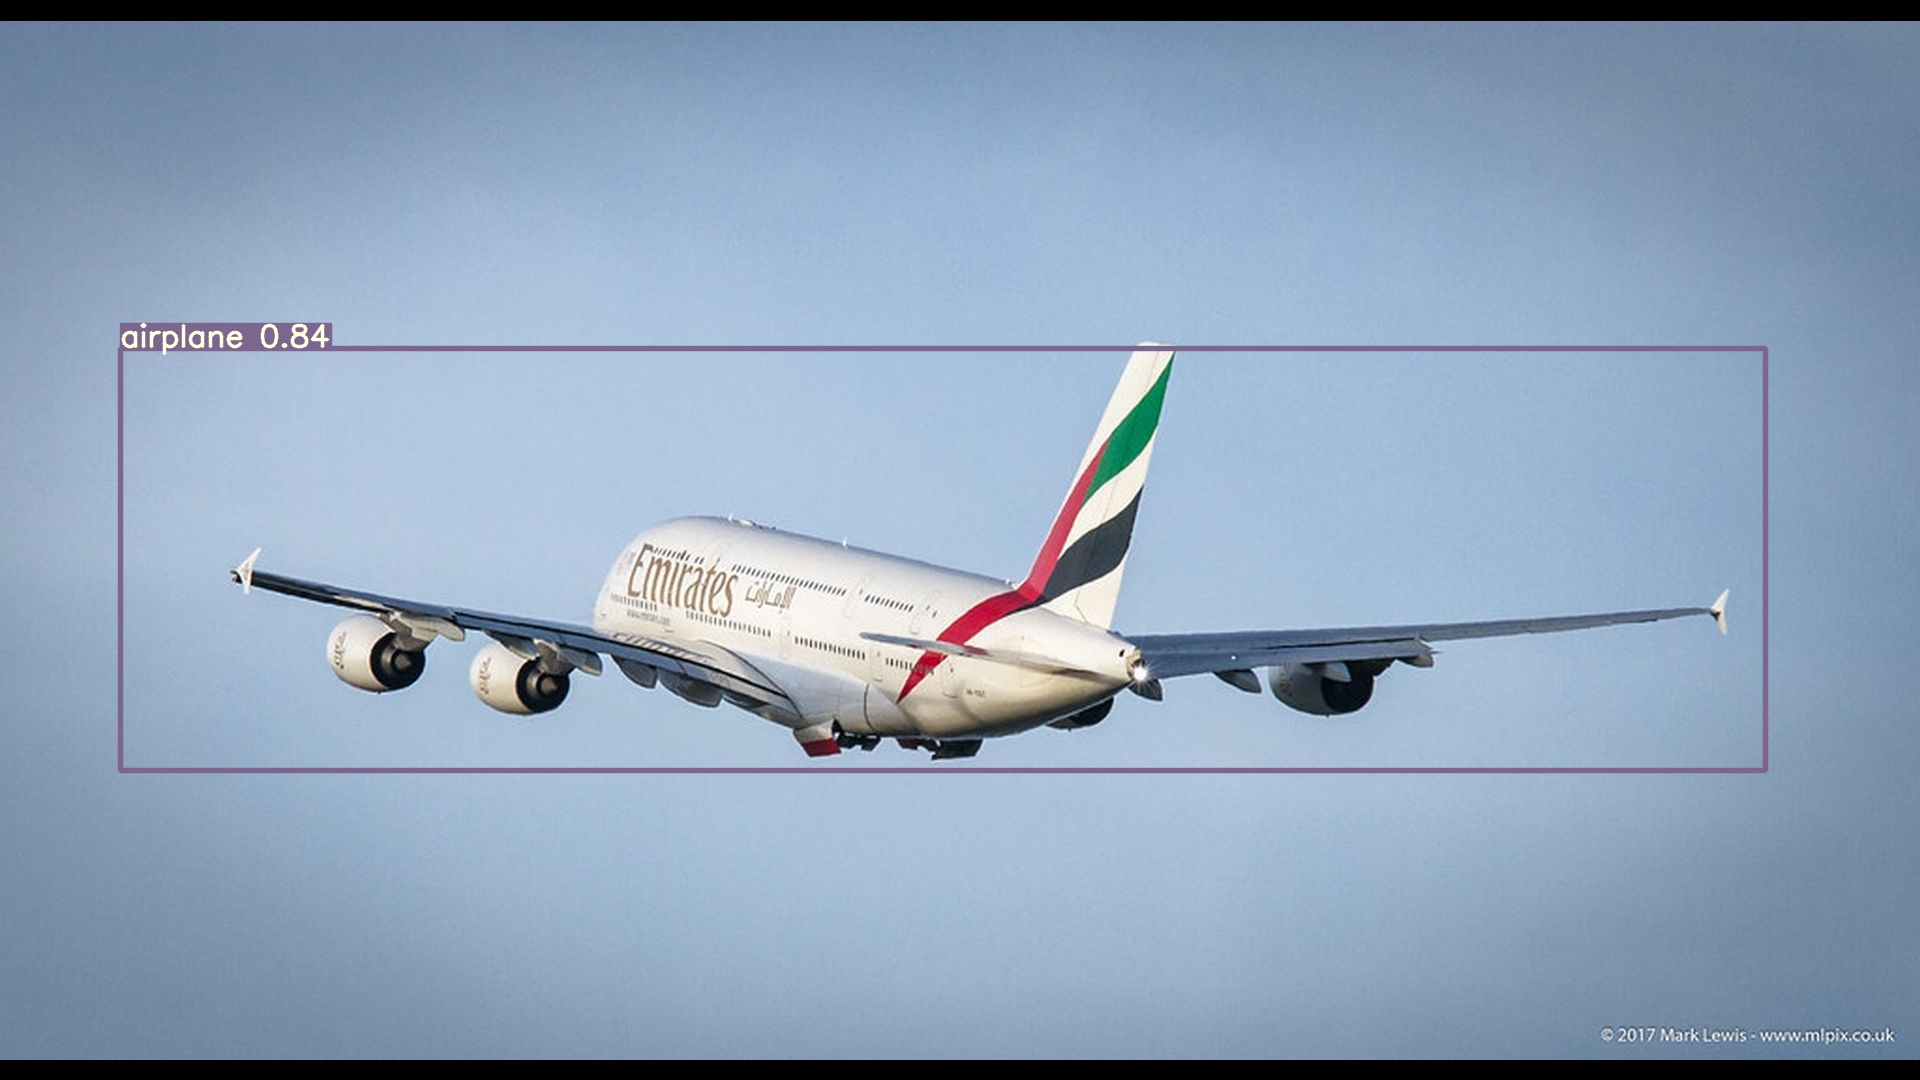

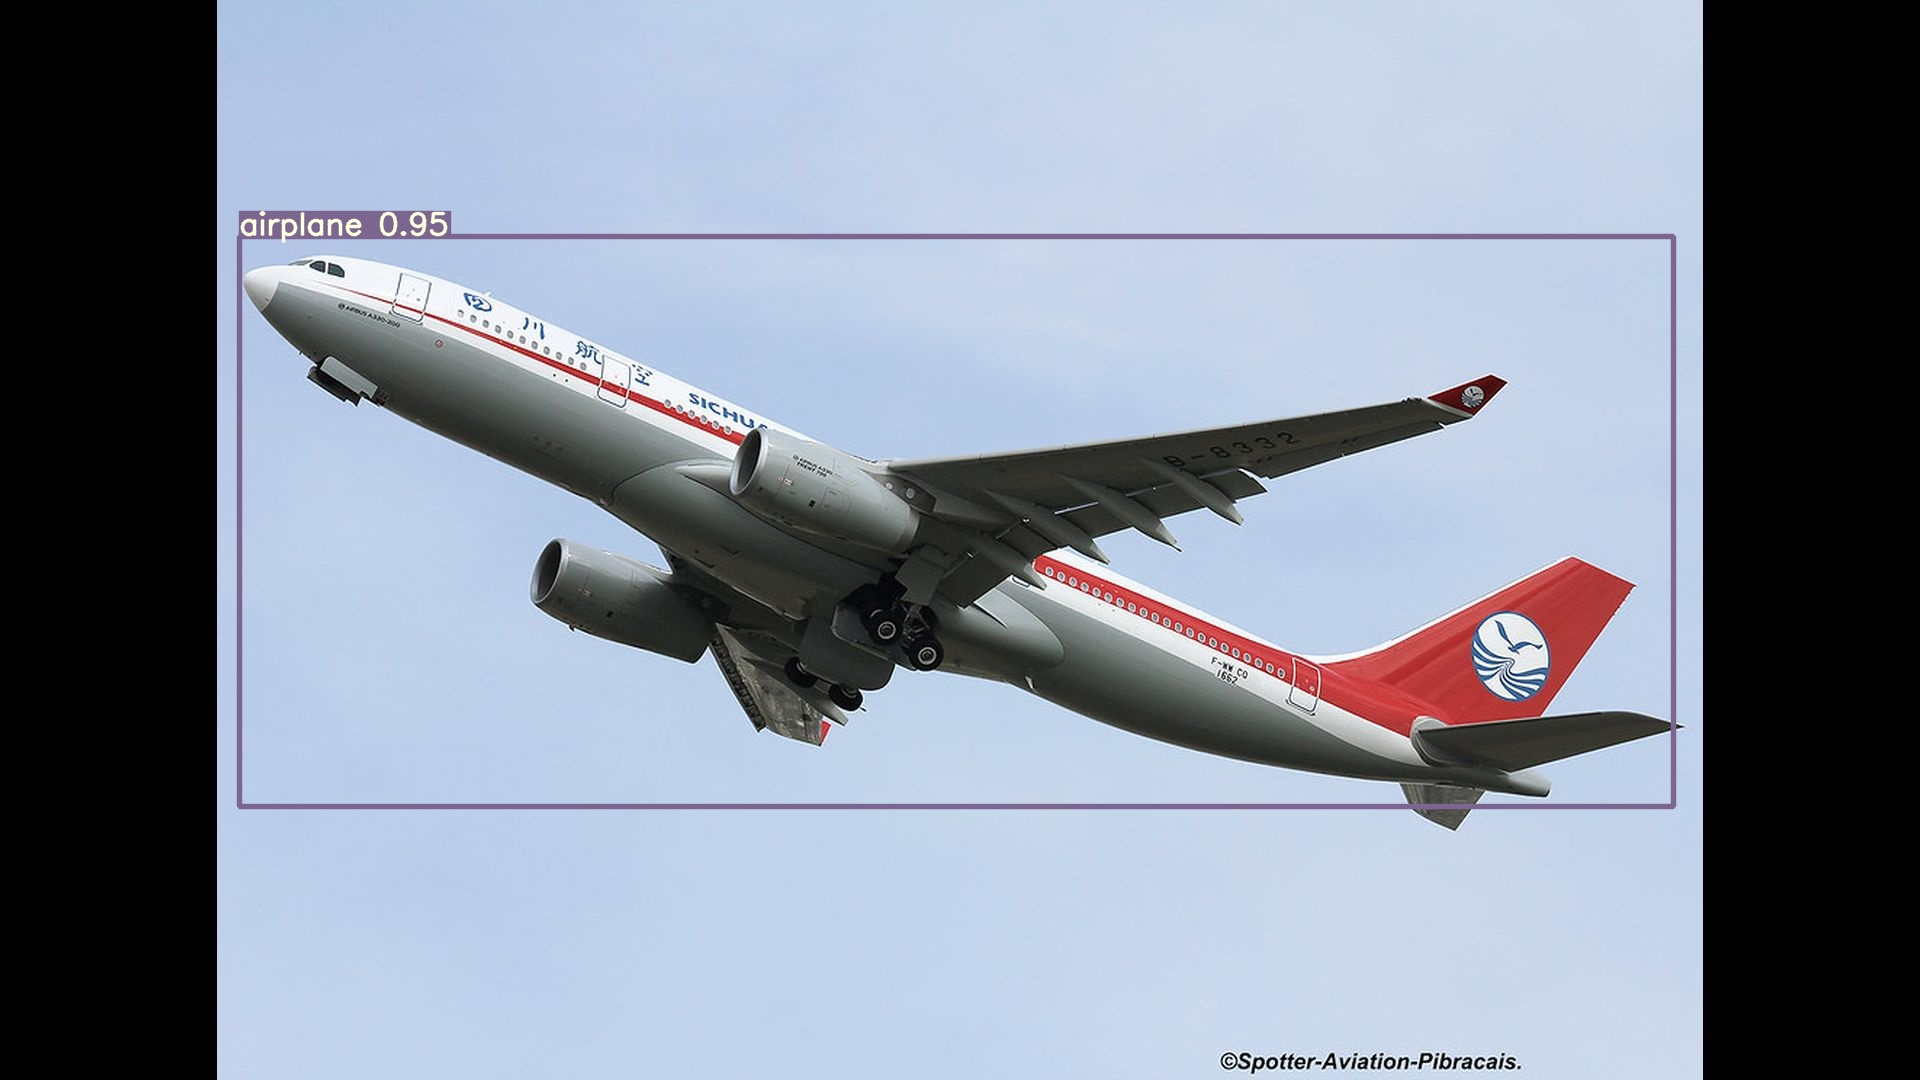

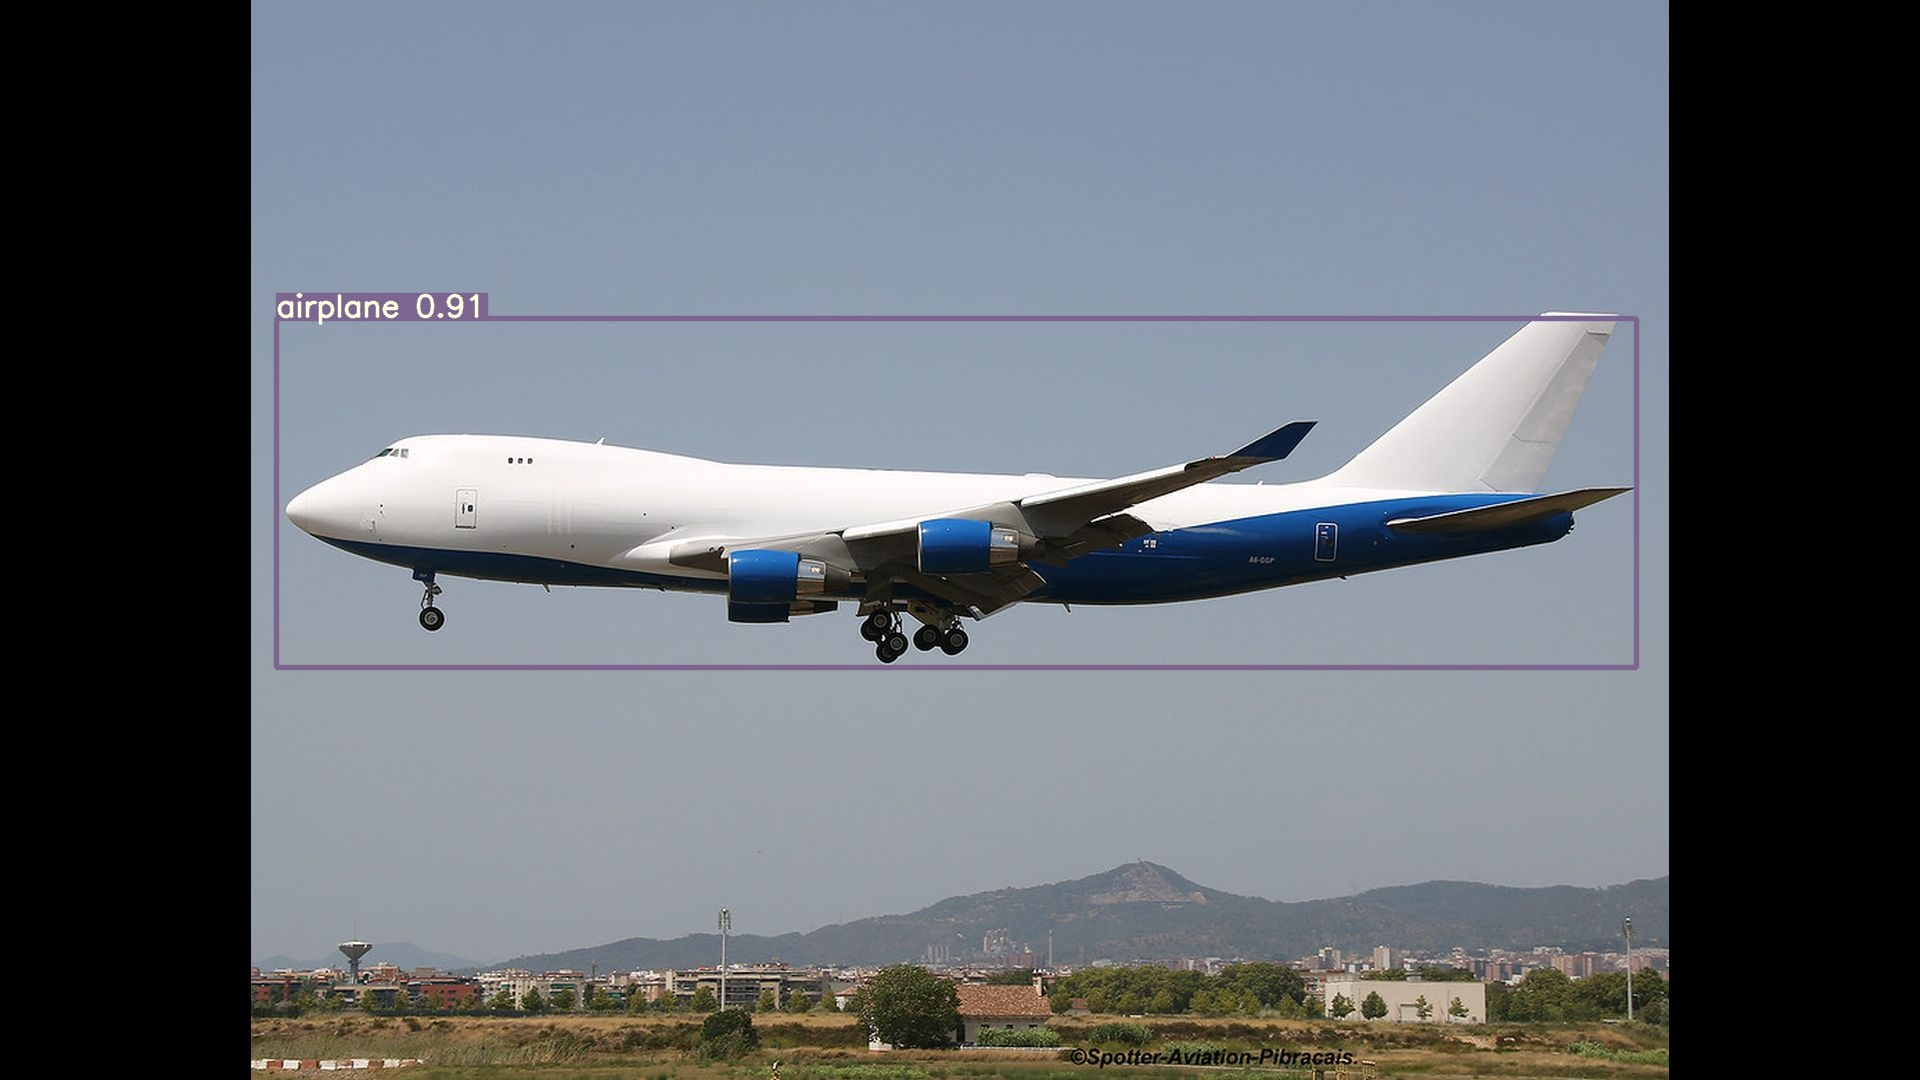

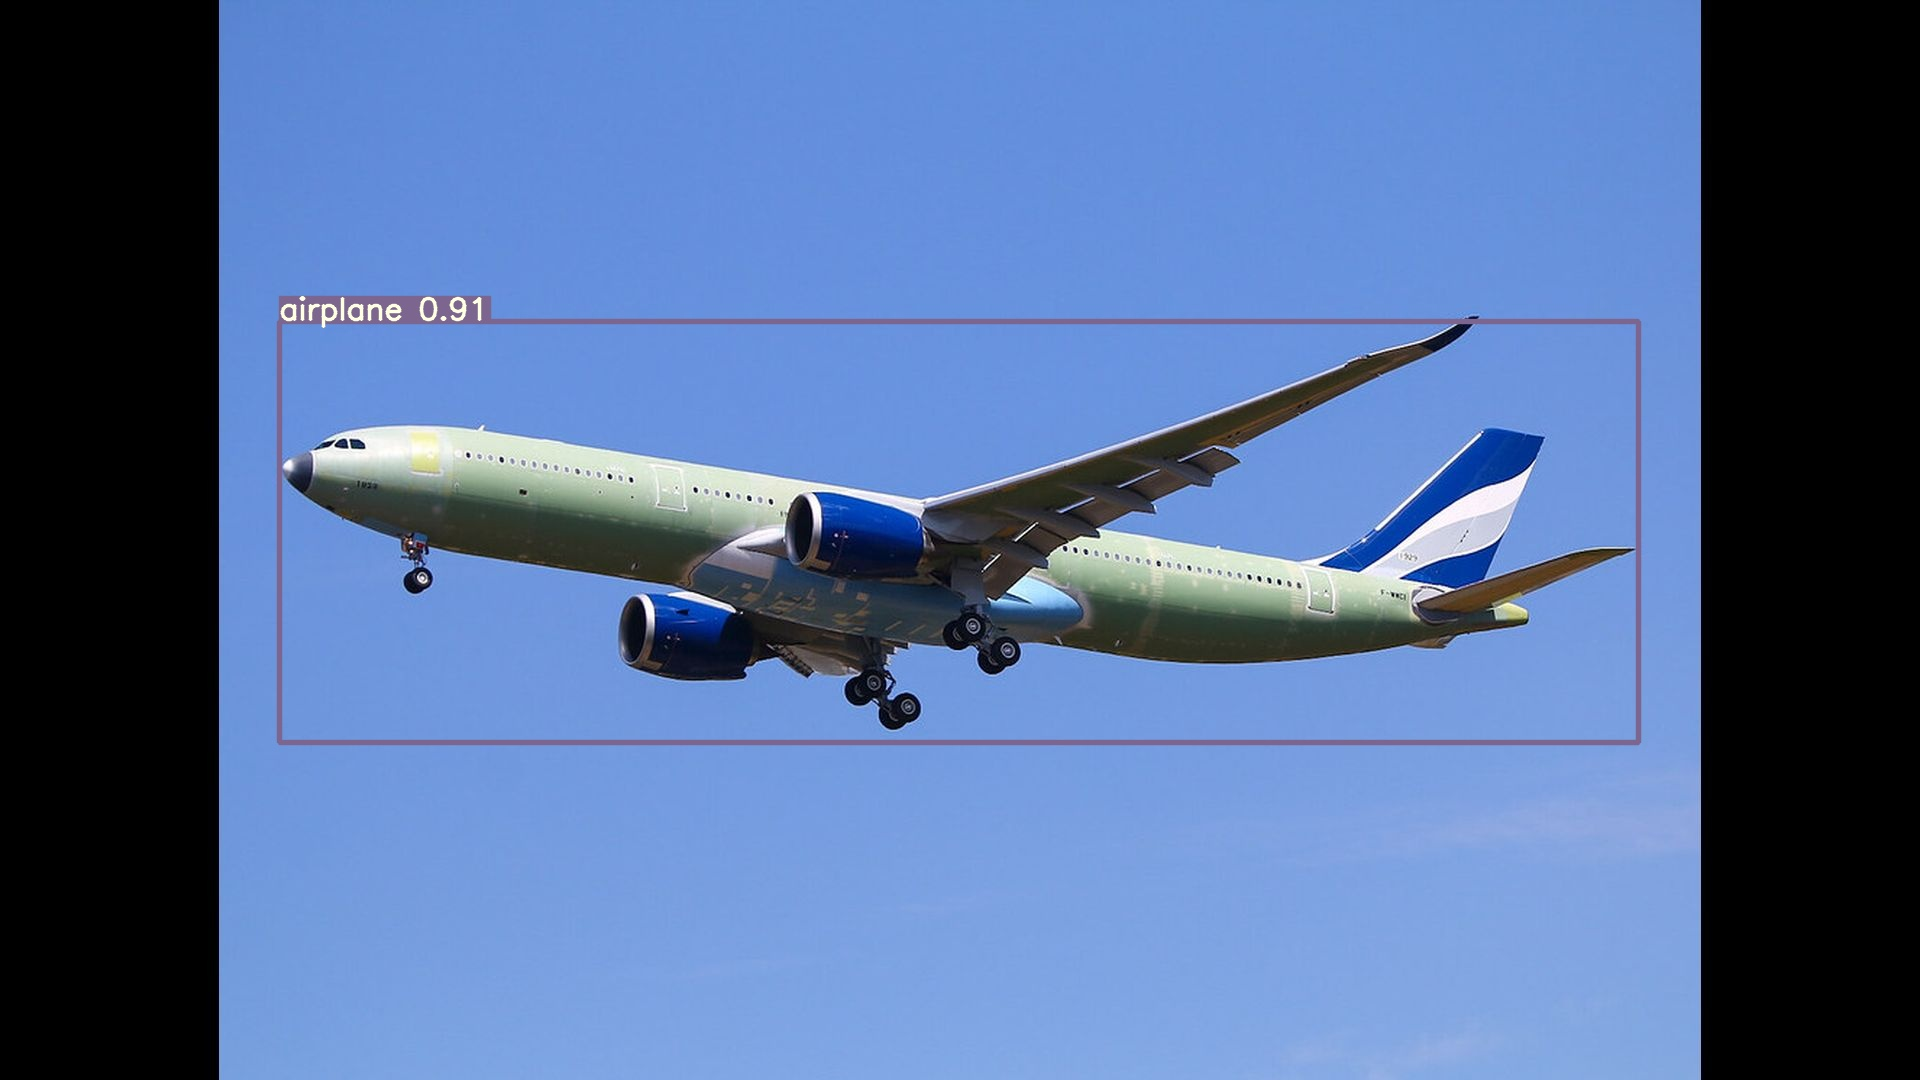

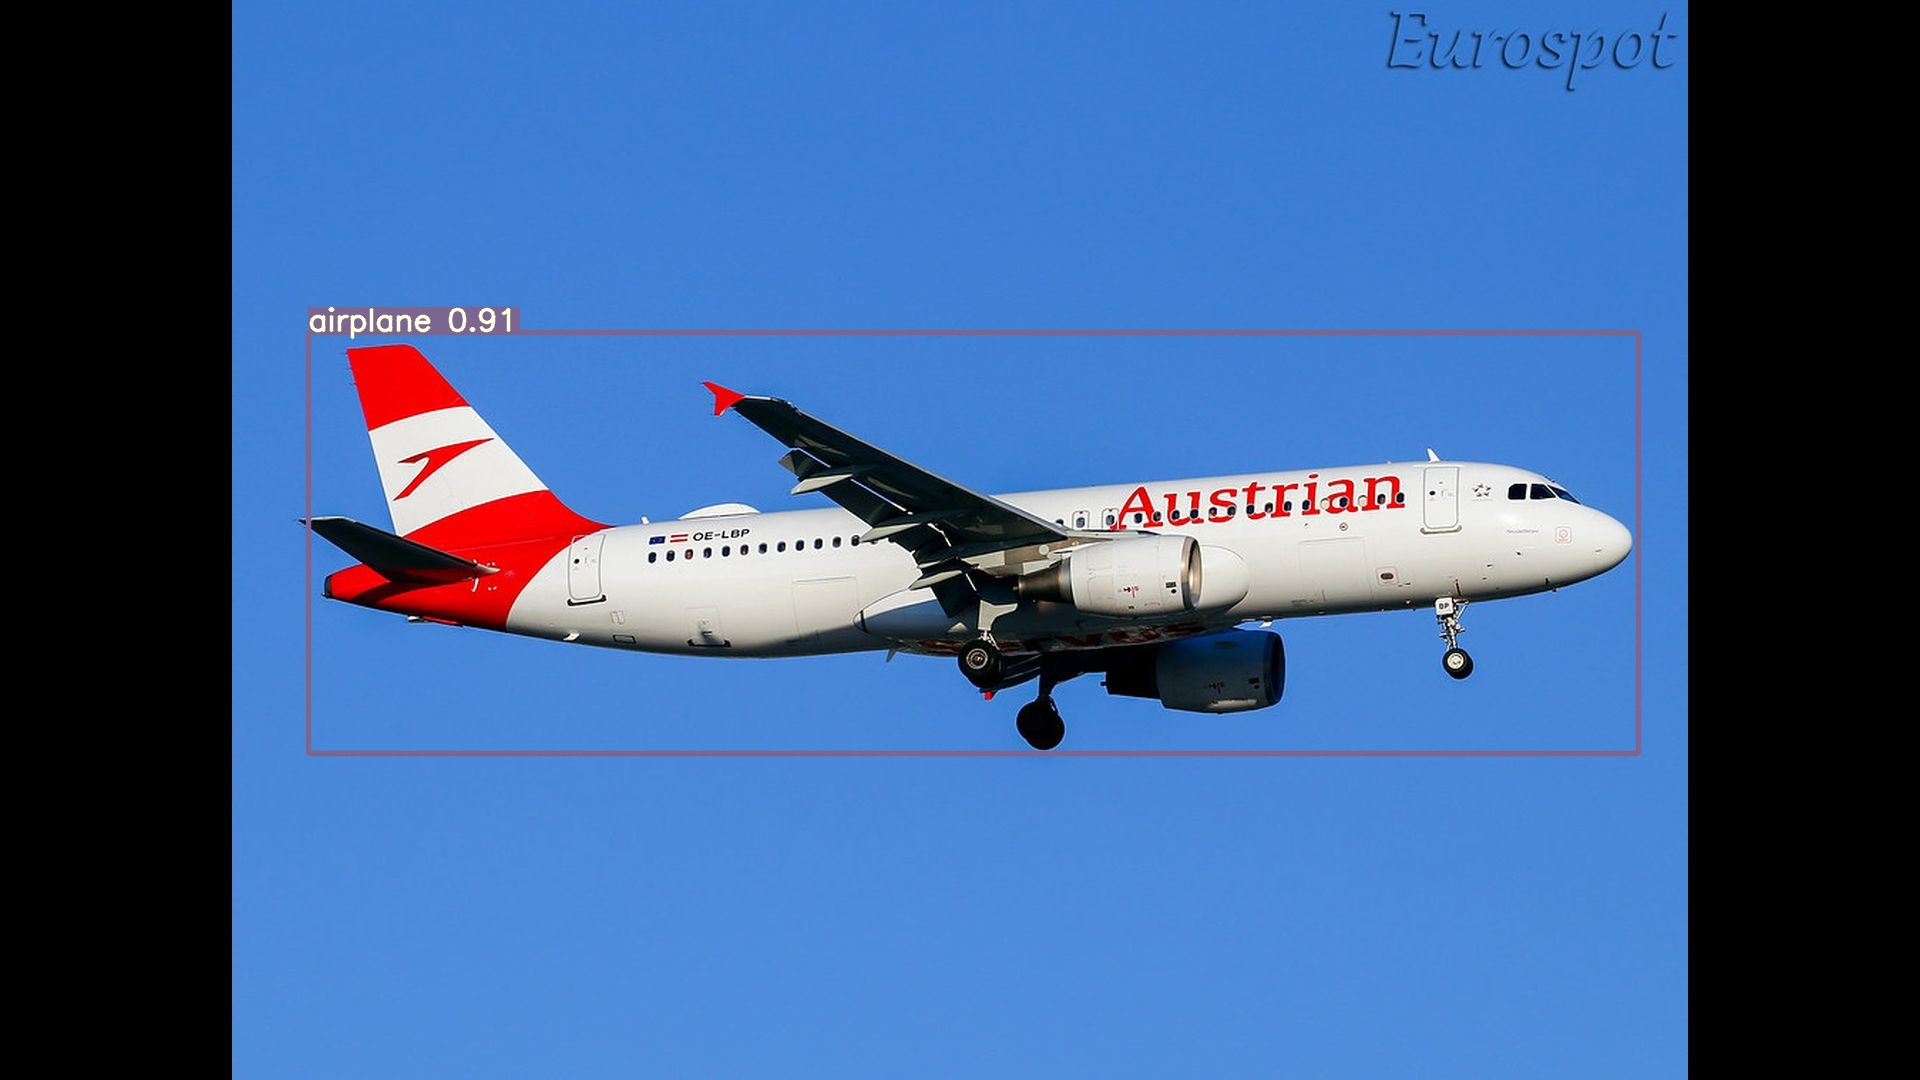

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above
# DISPLAY кончено тоже виснет, лучше больше 100-200 каритинок не давать
import glob
from IPython.display import Image as Image_for_display
from IPython.display import display

for imageName in glob.glob('/content/yolov5/runs/detect/exp4/*.jpg')[:5]: #assuming JPG
    display(Image_for_display(filename=imageName))
    print("\n")